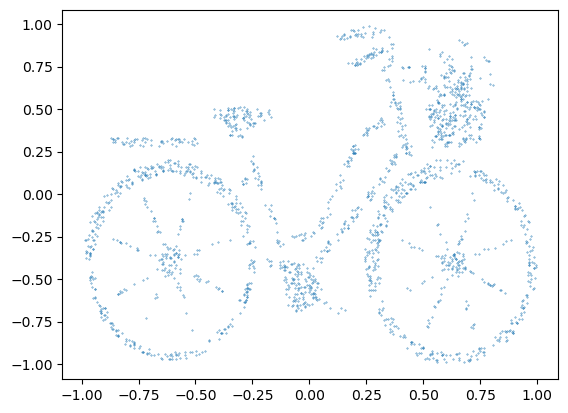

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

with open("bicycle.txt", "r") as file:
    points = []
    for line in file:
        points.append([float(i) for i in line.split()])
points = torch.tensor(points)


sample_indices = np.random.choice(points.shape[0], 2000)
sample_points = points[sample_indices]
fig, ax = plt.subplots()
ax.scatter(sample_points[:, 0], sample_points[:, 1], s=0.1)
fig.savefig("bicycle.png", dpi=300)

In [36]:
class LearnableSinusoidalEmbedding(torch.nn.Module):
    def __init__(self, seq_len=1000, encoding_dim=50, outer_dim=128, denom_base=1000):
        super().__init__()
        self.dim = encoding_dim
        self.seq_len = seq_len
        self.n = denom_base
        self.encodings = torch.zeros(seq_len, encoding_dim)

        for k in range(seq_len):
            for i in np.arange(int(encoding_dim / 2)):
                denominator = denom_base ** (2 * i / encoding_dim)
                self.encodings[k, 2 * i] = np.sin(k / denominator)
                self.encodings[k, 2 * i + 1] = np.cos(k / denominator)

        self.dense0 = torch.nn.Linear(encoding_dim, 128)
        self.relu0 = torch.nn.ReLU()
        self.dense1 = torch.nn.Linear(128, outer_dim)

    def forward(self, x):
        if isinstance(x, int):
            x = torch.tensor([x])
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        assert isinstance(x, torch.Tensor)
        assert len(x.shape) == 1
        assert x.shape[0] == 1
        x = self.encodings[x.long()]
        x = self.dense0(x)
        x = self.relu0(x)
        x = self.dense1(x)
        return x


class ConditionalDenseLayer(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, activation: torch.nn.Module = torch.nn.ReLU()
    ):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.dense = torch.nn.Linear(in_dim, out_dim)
        self.lse = LearnableSinusoidalEmbedding(outer_dim=out_dim,)
        self.activation = activation

    def forward(self, x: torch.Tensor, cond):
        x = self.dense(x)
        cond = self.lse(cond)
        x = x + cond
        x = self.activation(x)
        return x


class DiffussionGenerator(torch.nn.Module):
    def __init__(self, beta_start, beta_end, timesteps=1000):
        super().__init__()
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps

        # linear beta
        # self.betas = torch.linspace(beta_start, beta_end, timesteps)
        # self.alphas = torch.ones_like(self.betas) - self.betas
        # self.alphas_cumprod = torch.cumprod(self.alphas, 0)


        # sigmoid alphaprods
        border = 5
        self.alphas_cumprod = torch.sigmoid(torch.linspace(border, -border, timesteps))
        self.alphas = torch.zeros_like(self.alphas_cumprod)
        self.alphas[0] = self.alphas_cumprod[0]
        for i in range(1, timesteps):
            self.alphas[i] = self.alphas_cumprod[i] / self.alphas_cumprod[i-1]
        self.betas = torch.ones_like(self.alphas) - self.alphas


        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.one_minus_alphaprods = (
            torch.ones_like(self.alphas_cumprod) - self.alphas_cumprod
        )
        self.inv_sqrt_alphas = torch.ones_like(self.alphas) / torch.sqrt(self.alphas)
        self.sqrt_betas = torch.sqrt(self.betas)
        self.sqrt_ones_minus_alphas_cumprod = torch.sqrt(self.one_minus_alphaprods)
        self.last_coefs = self.betas / self.sqrt_ones_minus_alphas_cumprod

        assert self.alphas.isnan().sum() == 0
        assert self.betas.isnan().sum() == 0
        assert self.alphas_cumprod.isnan().sum() == 0
        assert self.sqrt_alphas_cumprod.isnan().sum() == 0
        assert self.one_minus_alphaprods.isnan().sum() == 0
        assert self.inv_sqrt_alphas.isnan().sum() == 0
        assert self.sqrt_betas.isnan().sum() == 0
        assert self.sqrt_ones_minus_alphas_cumprod.isnan().sum() == 0
        assert self.last_coefs.isnan().sum() == 0

        self.cdl0 = ConditionalDenseLayer(2, 128)
        self.cdl1 = ConditionalDenseLayer(128, 128)
        self.cdl2 = ConditionalDenseLayer(128, 128)
        self.cdl3 = ConditionalDenseLayer(128, 2, activation=torch.nn.Identity())

    def forward(self, x: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        x = self.cdl0(x, cond)
        x = self.cdl1(x, cond)
        x = self.cdl2(x, cond)
        x = self.cdl3(x, cond)
        return x

    def diffuse(self, points: torch.Tensor, timestep: int):
        noise = torch.randn_like(points)
        result = (
            points * self.sqrt_alphas_cumprod[timestep]
            + noise * self.one_minus_alphaprods[timestep]
        )
        return result, noise

    def sample(self, n: int):
        xs = []
        with torch.no_grad():
            x = torch.randn(n, 2)
            for t in range(self.timesteps - 1, -1, -1):
                z = torch.randn(n, 2) if t > 0 else torch.zeros(n, 2)
                z = self.sqrt_betas[t] * z
                # scaled_noise_pred = self(x, t) * self.last_coefs[t]
                x = self.inv_sqrt_alphas[t] * (x - self.last_coefs[t] * self(x, t)) + z
                xs.append(x)
        return torch.stack(xs, 0)

    def plot_alfacumprod(self, fname):
        fig, ax = plt.subplots()
        ax.plot(self.alphas_cumprod)
        ax.set_title("Alphas cumprod")
        ax.set_xlabel("timestep")
        ax.set_ylabel("alpha cumprod")
        fig.savefig(fname)
        plt.close(fig)

def test_model():
    model = DiffussionGenerator(0.0001, 0.02, timesteps=1000)
    random_input = torch.randn(10, 2)
    random_cond = torch.randint(0, 1000, (1,))
    result = model(random_input, random_cond)

    assert result.shape == random_input.shape


test_model()


In [47]:
timesteps = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffussionGenerator(0.0001, 0.02, timesteps=timesteps).to(device)
model.plot_alfacumprod("alfacumprod.png")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
dataloader = torch.utils.data.DataLoader(points, batch_size=128, shuffle=True)
epochs = 2001

mean_losses = []
for i in range(epochs):
    losses = []
    for batch in dataloader:
        optimizer.zero_grad()
        cond = torch.randint(0, model.timesteps, (1,))
        noised, noise = model.diffuse(batch, cond) # batch after diffusion and noise
        noise_pred = model(noised, cond)
        loss = loss_fn(noise_pred, noise)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    mean_loss = sum(losses) / len(losses)
    mean_losses.append(mean_loss)
    print(f"Epoch: {i}, Loss: {mean_loss}")
    if i % 100 == 0:
        torch.save(model.state_dict(), f"models/model_{i}.pt")
        print("Model saved")



Epoch: 0, Loss: 0.6325925809508072
Model saved
Epoch: 1, Loss: 0.47491776081556575
Epoch: 2, Loss: 0.4681035446215279
Epoch: 3, Loss: 0.5044413051167149
Epoch: 4, Loss: 0.4439324516637982
Epoch: 5, Loss: 0.4814073770000493
Epoch: 6, Loss: 0.46622623615556313
Epoch: 7, Loss: 0.4495404173631834
Epoch: 8, Loss: 0.46486966029469723
Epoch: 9, Loss: 0.4614513093558482
Epoch: 10, Loss: 0.48372598473878603
Epoch: 11, Loss: 0.44079752174689424
Epoch: 12, Loss: 0.5039754624230952
Epoch: 13, Loss: 0.47449907240092376
Epoch: 14, Loss: 0.42137662578798546
Epoch: 15, Loss: 0.4490563167111736
Epoch: 16, Loss: 0.4257166739570896
Epoch: 17, Loss: 0.47360789644873785
Epoch: 18, Loss: 0.440761893163612
Epoch: 19, Loss: 0.4772514354985773
Epoch: 20, Loss: 0.44829777478110755
Epoch: 21, Loss: 0.47568810082665536
Epoch: 22, Loss: 0.4450343557774926
Epoch: 23, Loss: 0.46825106566347463
Epoch: 24, Loss: 0.5000557605560303
Epoch: 25, Loss: 0.495160914524871
Epoch: 26, Loss: 0.46561045996443945
Epoch: 27, Loss:

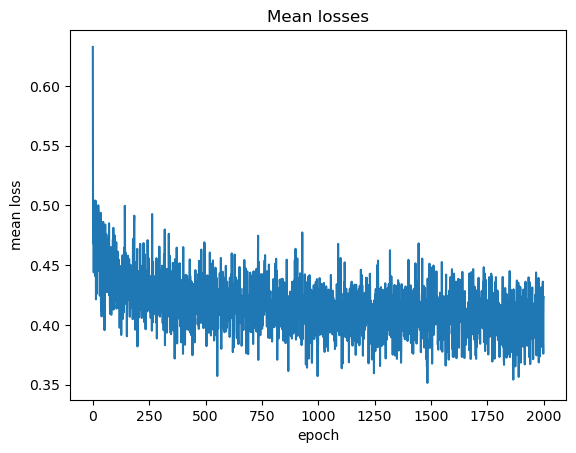

In [48]:
# plot mean losses
fig, ax = plt.subplots()
ax.plot(mean_losses)
ax.set_title("Mean losses")
ax.set_xlabel("epoch")
ax.set_ylabel("mean loss")
fig.savefig("mean_losses.png")

In [87]:
import gc

results = model.sample(40000)


def plot_result(timestep, result):
    fig, ax = plt.subplots()
    ax.scatter(result[:, 0], result[:, 1], s=0.1)
    ax.set_title(f"timestep {timestep}")
    fig.savefig(f"samples/sample_{timestep}.png")
    plt.close(fig)

!rm samples/*

for i, result in enumerate(results):
    if i < 950:
        if i % 20 == 0:
            plot_result(i, result)
            print(f"Plot {i} done", end="\r")
    else:
        plot_result(i, result)

In [88]:
from PIL import Image
import os

# Set the directory path
directory = "samples"

# Get the list of image files in the directory
image_files = [file for file in os.listdir(directory) if file.endswith(".png")]

# Sort the image files in ascending order
image_files.sort(key = lambda x: int(x.split("_")[1].split(".")[0]))

# Create a list to store the images
images = []

# Read each image file and append it to the list
for file in image_files[::]:
    image_path = os.path.join(directory, file)
    image = Image.open(image_path)
    images.append(image)

# Save the images as a GIF
gif_path = "animation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], fps=10, loop=1)

print("GIF created successfully!")


GIF created successfully!


In [84]:
model = DiffussionGenerator(0.0001, 0.02, timesteps=1000)
model.load_state_dict(torch.load("models/model_2000.pt"))

<All keys matched successfully>